In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

In [43]:
def ff(x, omega):
    # return omega
    # If you just return ff=omega, this gives the usual Classifier free guidance, the same as the one
    # called 'linear' in the calc_score function
    return omega/(x**.75+1.e-6)


def calc_score(itau, dt, itfms, omega, q):
    expt = np.exp(-dt*(itfms-itau))
    linear = expt*(1+omega-omega*np.tanh(q*expt))
    nonlinear = expt*(1+(1 - np.tanh(q*expt)) *
                      ff(expt*(1-np.tanh(q*expt)), omega))
    normdiff = expt*(1-np.tanh(q*expt))  # Norm of S_full-S_class
    return nonlinear, normdiff


def init_backward():
    return np.random.normal(0, 1)


def calc_traj_back_exact(qinit, nt, dt, itfms, omega):
    qback = np.zeros(nt)
    time = np.zeros(nt)
    normd = np.zeros(nt)
    qback[0] = qinit
    q = qback[0]
    time[0] = 0
    for it in np.arange(nt-1):
        eta = np.random.normal(0, np.sqrt(2*dt))
        # rx=xback[it,:]
        sc, normdiff = calc_score(it, dt, itfms, omega, q)
        q = (1-dt)*q+2*dt*sc+eta
        qback[it+1] = q
        time[it+1] = it*dt
        normd[it] = normdiff
    return time, qback,normd

In [44]:
#Here we run three single trajectories just to have a look
qinit=init_backward()
dt=.01 # K: timesteps
nt=800 #final time is nt*dt
ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns
print('iterations nt=',nt,'time step dt=',dt,'speciation ns=',ns)
omega=0
time,qtraj0,normdiff0=calc_traj_back_exact(qinit,nt,dt,itfms,omega)
omega=2
time,qtraj1,normdiff1=calc_traj_back_exact(qinit,nt,dt,itfms,omega)
omega=4
time,qtraj2,normdiff2=calc_traj_back_exact(qinit,nt,dt,itfms,omega)

iterations nt= 800 time step dt= 0.01 speciation ns= 200


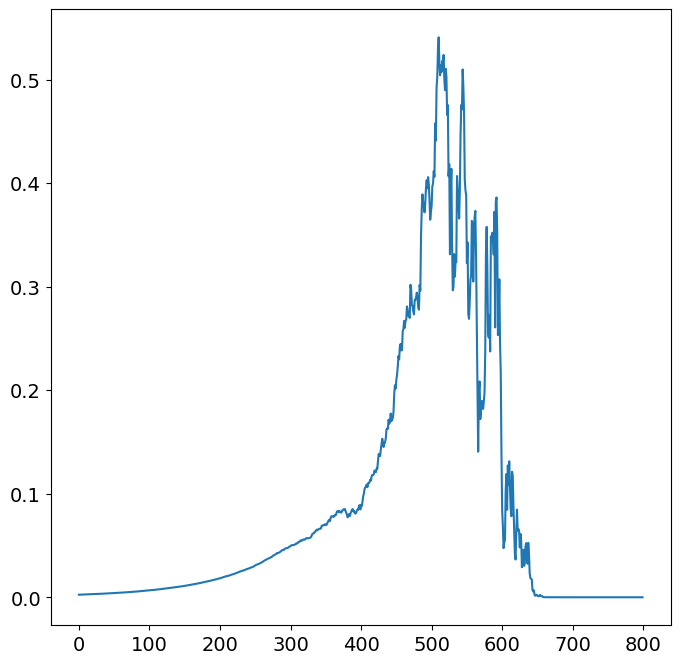

In [45]:
# time goes from 0 to 8
# paths all end up in mu=1
plt.plot(normdiff0)

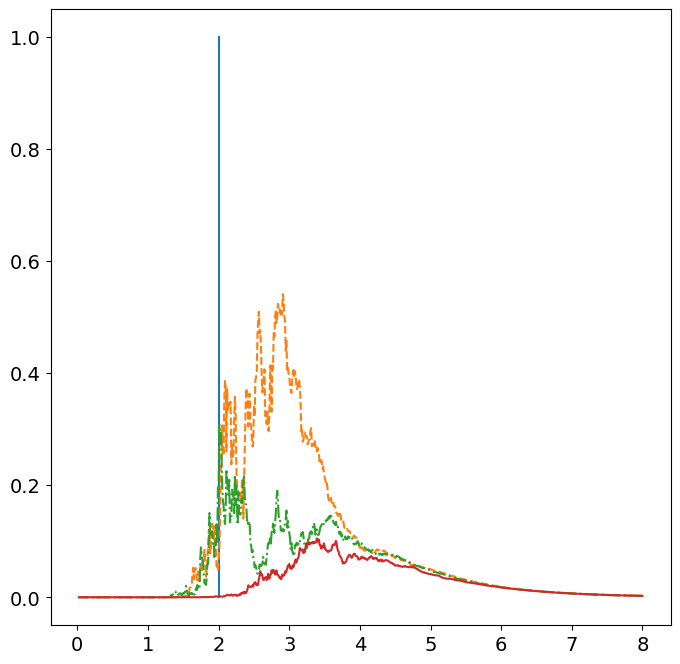

In [46]:
#plt.plot(nt*dt-time,qtraj0)
#plt.plot(nt*dt-time,qtraj1)
#plt.plot(nt*dt-time,qtraj4)
plt.plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0,1])
plt.plot(nt*dt-time,normdiff0,'--')
plt.plot(nt*dt-time,normdiff1,'-.')
plt.plot(nt*dt-time,normdiff2)
#plt.axis([0,6,0,.5])

In [47]:
#Run nsample trajectories 
nsample=100
dt=.01
nt=800 #final time is nt*dt
ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns

nomega=5
omegag=np.zeros(nomega)
qtraj=np.zeros((nomega,nsample,nt))
normstat=np.zeros((nomega,nsample,nt))
for ijk in np.arange(nsample):
    qinit=init_backward()
    for iomega in np.arange(nomega):
        omega=4*iomega
        omegag[iomega]=omega
        time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega)

omega= 0.0
omega= 4.0
omega= 8.0
omega= 12.0
omega= 16.0


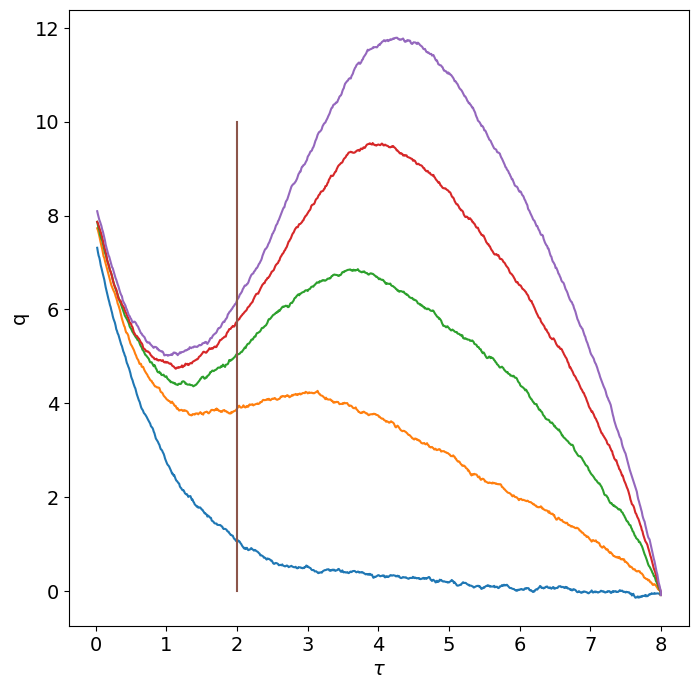

In [48]:
for iomega in np.arange(nomega):
    print('omega=',omegag[iomega])
    qav=np.mean(qtraj,axis=1)
    plt.plot(nt*dt-time,qav[iomega,:])
plt.plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0,10])
plt.xlabel(r'$\tau$')
plt.ylabel('q')
#plt.text(7,8,'$\omega=0$ to $16$')
# plt.axis([0,12,-1,15])
#plt.savefig('free-guidance-gaussian-mixture-q-backward_v3.pdf')
plt.show()

omega= 0.0
omega= 4.0
omega= 8.0
omega= 12.0
omega= 16.0


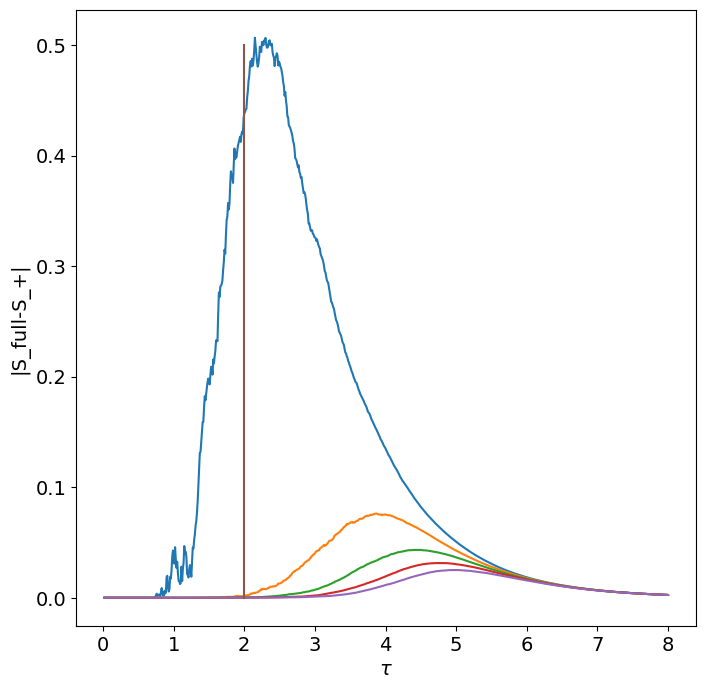

In [16]:
for iomega in np.arange(nomega):
    print('omega=',omegag[iomega])
    normav=np.mean(normstat,axis=1)
    plt.plot(nt*dt-time,normav[iomega,:])
plt.plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0,.5])
plt.xlabel(r'$\tau$')
plt.ylabel('|S_full-S_+|')
#plt.text(7,8,'$\omega=0$ to $16$')
#plt.axis([0,12,-1,10])
#plt.savefig('free-guidance-gaussian-mixture-q-backward_v3.pdf')
plt.show()